# 6.1 Sequence Models

- People’s opinions on movies can change quite significantly over time. In fact, psychologists even have names for some of the effects:
  - ***Anchoring*** based on someone else’s opinion.
    - For instance after the Oscara wards, ratings for the corresponding movie go up, even though it’s still the same movie. This effect persists for a few months until the award is forgotten. 
  - ***Hedonic adaptation*** where humans quickly adapt to accept an improved (or a bad) situation as the new normal.     - For instance, after watching many good movies, the expectations that the next movie be equally good or better are high, and even an average movie might be considered a bad movie after many great ones.
  - ***Seasonality***
    - Very few viewers like to watch a Santa Claus movie in August.
  - In some cases movies become unpopular due to the misbehaviors of directors or actors in the production.
  - Some movies become cult movies, because they were almost comically bad. 
- Other examples
  - Many users have highly particular behavior when it comes to the time when they open apps. 
    - For instance, social media apps are much more popular after school with students. 
    - Stock market trading apps are more commonly used when the markets are open.
  - It is much harder to predict tomorrow's stock prices than to fill in the blanks for a stock price we missed yesterday
    - In statistics the former is called prediction whereas the latter is called filtering.
    - After all, hindsight is so much easier than foresight. 
  - Music, speech, text, movies, steps, etc. are all sequential in nature. 
    - If we were to permute them they would make little sense. 
    - The headline dog bites man is much less surprising than man bites dog, even though the words are identical.
  - Earthquakes are strongly correlated, i.e. after a massive earthquake there are very likely several smaller aftershocks, much more so than without the strong quake. 
    - In fact, earthquakes are spatiotemporally correlated, i.e. the aftershocks typically occur within a short time span and in close proximity.
  - Humans interact with each other in a sequential nature, as can be seen in Twitter fights, dance patterns and debates.


## 6.1.1 Statistical Tools
![](https://github.com/d2l-ai/d2l-en/raw/master/img/ftse100.png)

- Let's denote the prices by $x_t \geq 0$, i.e. at time $t \in \mathbb{N}$ we observe some price $x_t$. 
- For a trader to do well in the stock market on day $t$ he should want to predict $x_t$ via $$x_t \sim p(x_t|x_{t-1}, \ldots x_1).$$
- Autoregressive Models
  - In order to achieve this, our trader could use a regressor.
  - There's just a major problem - the number of inputs, $x_{t-1}, \ldots x_1$ varies, depending on $t$. 
    - That is, the number increases with the amount of data that we encounter
    - We need an approximation to make this computationally tractable. Two strategies:
      - 1) Assume that the potentially rather long sequence $x_{t-1}, \ldots x_1$ isn't really necessary. 
        - In this case we might content ourselves with some timespan $\tau$ and only use $x_{t-1}, \ldots x_{t-\tau}$ observations. 
        - The number of arguments is always the same, at least for $t > \tau$. 
        - Such models will be called ***autoregressive models***, as they quite literally perform regression on themselves.
      - 2) Try and keep some summary $h_t$ of the past observations around and update that in addition to the actual prediction. 
        - This leads to models that estimate $x_t|x_{t-1}, h_{t-1}$ and moreover updates of the form $h_t = g(h_t, x_t)$. 
        - Since $h_t$ is never observed, these models are also called ***latent autoregressive models***. 
        - LSTMs and GRUs are exampes of this.
    - Both cases raise the obvious question how to generate training data. 
      - One typically uses historical observations to predict the next observation given the ones up to right now.
    - However, a common assumption is that while the specific values of $x_t$ might change, at least the dynamics of the time series itself won't. 
      - This is reasonable, since novel dynamics are not predictable using data we have so far. 
    - Statisticians call dynamics that don't change ***stationary***. 
    - Regardless of what we do, we will thus get an estimate of the entire time series via $$p(x_1, \ldots x_T) = \prod_{t=1}^T p(x_t|x_{t-1}, \ldots x_1).$$
    - Note that the above considerations still hold even if we deal with discrete objects, such as words, rather than numbers. 
      - The only difference is that in such a situation we need to use a classifier rather than a regressor to estimate $p(x_t| x_{t-1}, \ldots x_1)$.
  
- Markov Model
  - In an autoregressive model, we use only $(x_{t-1}, \ldots x_{t-\tau})$ instead of $(x_{t-1}, \ldots x_1)$ to estimate $x_t$.
  - Whenever this approximation is accurate we say that the sequence satisfies a ***Markov condition***. 
    - In particular, if $\tau = 1$, we have a first order Markov model and $p(x)$ is given by $$p(x_1, \ldots x_T) = \prod_{t=1}^T p(x_t|x_{t-1}).$$
  - Such models are particularly nice whenever $x_t$ assumes only discrete values, since in this case dynamic programming can be used to compute values along the chain exactly. 
    - For instance, we can compute $x_{t+1}|x_{t-1}$ efficiently using the fact that we only need to take into account a very short history of past observations. $$p(x_{t+1}|x_{t-1}) = \sum_{x_t} p(x_{t+1}|x_t) p(x_t|x_{t-1})$$

- Causality
  - In principle, there's nothing wrong with unfolding $p(x_1, \ldots x_T)$ in reverse order. $$p(x_1, \ldots x_T) = \prod_{t=T}^1 p(x_t|x_{t+1}, \ldots x_T).$$

    - In fact, if we have a Markov model we can obtain a reverse conditional probability distribution, too. 
  - In many cases, however, there exists a natural direction for the data, namely going forward in time. 
  - It is clear that future events cannot influence the past. 
    - If we change $x_t$, we may be able to influence what happens for $x_{t+1}$ going forward but not the converse. 
    - If we change $x_t$, the distribution over past events will not change. 
    - It ought to be easier to explain $x_{t+1}|x_t$ rather than $x_t|x_{t+1}$. 
  - For instance, Hoyer et al., 2008 show that in some cases we can find $x_{t+1} = f(x_t) + \epsilon$ for some additive noise, whereas the converse is not true. 
  - This is great news, since it is typically the forward direction that we're interested in estimating. 

## 6.1.2 Toy Example
- Let’s begin by generating ‘time series’ data by using a sine function with some additive noise.

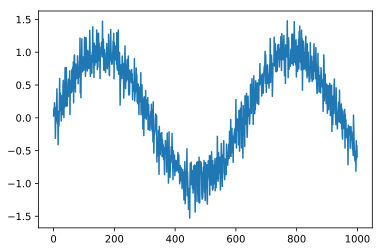

In [12]:
from mxnet import autograd, nd, gluon, init
import gluonbook as gb
# display routines
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

embedding = 4 # embedding dimension for autoregressive model

T = 1000      # generate a total of 1000 points 
time = nd.arange(0,T)
x = nd.sin(0.01 * time) + 0.2 * nd.random.normal(shape=(T))

plt.plot(time.asnumpy(), x.asnumpy());

- Next we need to turn this 'time series' into data the network can train on. 
- Based on the embedding dimension $\tau$ we map the data into pairs $y_t = x_t$ and $\mathbf{z}_t = (x_{t-1}, \ldots x_{t-\tau})$. 
- The astute reader might have noticed that this gives us $\tau$ fewer datapoints, since we don't have sufficient history for the first $\tau$ of them. 
  - A simple fix is to discard those few terms. 
  - Alternatively we could pad the time series with zeros. 

In [13]:
features = nd.zeros((T-embedding, embedding)) # (1000 - 4, 4) = (996, 4)

# features[:, 0] = x[0:996]
# features[:, 1] = x[1:997]
# features[:, 2] = x[2:998]
# features[:, 3] = x[3:999]
for i in range(embedding):
    features[:, i] = x[i:T - embedding + i]

# labels = x[4:]
labels = x[embedding:]

ntrain = 600
train_data = gluon.data.ArrayDataset(features[:ntrain,:], labels[:ntrain])
test_data  = gluon.data.ArrayDataset(features[ntrain:,:], labels[ntrain:])

# vanilla MLP architecture
def get_net():
    net = gluon.nn.Sequential()
    net.add(gluon.nn.Dense(10, activation='relu'))
    net.add(gluon.nn.Dense(10, activation='relu'))
    net.add(gluon.nn.Dense(1))
    net.initialize(init=init.Xavier(), force_reinit=True)
    return net

# least mean squares loss
loss = gluon.loss.L2Loss()

In [14]:
# simple optimizer using adam, random shuffle and minibatch size 16
def train_net(net, data, loss, epochs, learning_rate):
    batch_size = 16
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate})
    data_iter = gluon.data.DataLoader(data, batch_size, shuffle=True)

    for epoch in range(1, epochs + 1):
        for X, y in data_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        l = loss(net(data[:][0]), nd.array(data[:][1]))
        print('epoch %d, loss: %f' % (epoch, l.mean().asnumpy()))
    return net

net = get_net()
net = train_net(
    net=net, 
    data=train_data, 
    loss=loss, 
    epochs=10, 
    learning_rate=0.01
)

l = loss(net(test_data[:][0]), nd.array(test_data[:][1]))
print('test loss: %f' % l.mean().asnumpy())

epoch 1, loss: 0.026710
epoch 2, loss: 0.025081
epoch 3, loss: 0.025592
epoch 4, loss: 0.026057
epoch 5, loss: 0.027615
epoch 6, loss: 0.024617
epoch 7, loss: 0.023896
epoch 8, loss: 0.024280
epoch 9, loss: 0.024480
epoch 10, loss: 0.026319
test loss: 0.028010


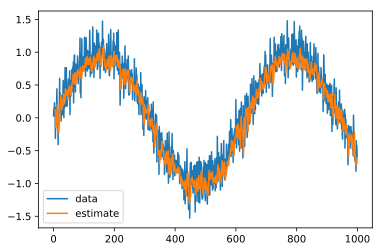

In [15]:
estimates = net(features)
plt.plot(time.asnumpy(), x.asnumpy(), label='data');
plt.plot(time[embedding:].asnumpy(), estimates.asnumpy(), label='estimate');
plt.legend();

## 6.1.3 Predictions

- If we observe data only until time step 600, we cannot hope to receive the ground truth for all future predictions. 
- Instead, we need to work our way forward one step at a time:

$$\begin{aligned} x_{601} & = f(x_{600}, \ldots, x_{597}) \\ x_{602} & = f(x_{601}, \ldots, x_{598}) \\ x_{603} & = f(x_{602}, \ldots, x_{599}) \end{aligned}$$

- In other words, very quickly will we have to use our own predictions to make future predictions.

In [16]:
estimates.shape

(996, 1)

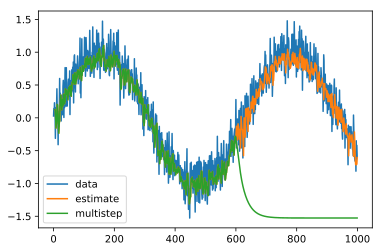

In [17]:
predictions = nd.zeros_like(estimates)

# ntrain - embedding = 600 - 4 = 596
predictions[:(ntrain-embedding)] = estimates[:(ntrain-embedding)]

# T - embedding = 996
for i in range(ntrain-embedding, T-embedding):
    predictions[i] = net(predictions[(i-embedding):i].reshape(1,-1)).reshape(1)
    
plt.plot(time.asnumpy(), x.asnumpy(), label='data');
plt.plot(time[embedding:].asnumpy(), estimates.asnumpy(), label='estimate');
plt.plot(time[embedding:].asnumpy(), predictions.asnumpy(), label='multistep');
plt.legend();

- This is ultimately due to the fact that errors build up. 
- Let's say that after step 1 we have some error $\epsilon_1 = \bar\epsilon$. 
- Now the input for step 2 is perturbed by $\epsilon_1$, hence we suffer some error in the order of $\epsilon_2 = \bar\epsilon + L \epsilon_1$, and so on. 
- The error can diverge rather rapidly from the true observations. 
- This is a common phenomenon - for instance weather forecasts for the next 24 hours tend to be pretty accurate but beyond that their accuracy declines rapidly.
- Let’s verify this observation by computing the k-step predictions on the entire sequence.

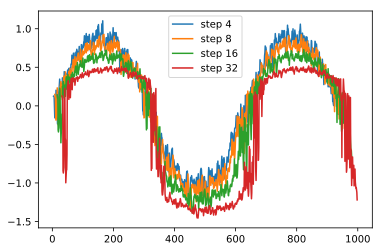

In [18]:
k = 33 # look up to k - embedding steps ahead

# T-k = 1000-33 = 967
features = nd.zeros((T-k, k))

# features[:, 0] = x[0:967]
# features[:, 1] = x[1:968]
# features[:, 2] = x[2:969]
# features[:, 3] = x[3:970]
for i in range(embedding):
    features[:,i] = x[i:T-k+i]

# features[:, 4] = net(features[:, 0:4]).reshape((-1))
# features[:, 5] = net(features[:, 1:5]).reshape((-1))
# ...
# features[:, 32] = net(features[:, 28:32]).reshape((-1))
for i in range(embedding, k):
    features[:,i] = net(features[:,(i-embedding):i]).reshape((-1))
    
for i in (4, 8, 16, 32):   
    plt.plot(time[i:T-k+i].asnumpy(), features[:,i].asnumpy(), label=('step ' + str(i)))
plt.legend();

## Summary
- Sequence models require specialized statistical tools for estimation. 
  - Two popular choices are autoregressive models and latent-variable autoregressive models.
- As we predict further in time, the errors accumulate and the quality of the estimates degrades, often dramatically.
- There’s quite a difference in difficulty between filling in the blanks in a sequence (smoothing) and forecasting. 
  - Consequently, if you have a time series, always respect the temporal order of the data when training, i.e. never train on future data.


# 6.2 Language Models